# Tweet Sentiment Extraction

[*Kaggle competition*](https://www.kaggle.com/c/tweet-sentiment-extraction/overview/description)

**Task:** identify the words and phrases associated with good/neutral/bad sentiments of tweets

**Input/Data:** the training data has tweets, the selected text from the tweets that represent the sentiment, and the sentiment score (categorical good/bad/neutral); the test data includes the same except for the selected text

**Output:** CSV file with tweet ID and selected text that represents the tweets' sentiments

**Approach:** Question Answering model with distilled BERT transformer (DistilBERT). This approach follows very closely that of [Keras QA example](https://keras.io/examples/nlp/text_extraction_with_bert/): "BERT (from Huggingface Transformers) for Text Extraction"

# Preparation

In [ ]:
# Import necessary modules
import os
import re
import json
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig

max_len = 141
configuration = BertConfig()  # default paramters and configuration for BERT

# Get and Explore the Data

In [ ]:
# Load the train and test datasets
file_test = '/content/sample_data/Kaggle_Twitter_sentiment_test.csv'
file_train = '/content/sample_data/Kaggle_Twitter_sentiment_train.csv'
# Read as a pandas dataframe
test_data = pd.read_csv(file_test)
train_data = pd.read_csv(file_train)

In [ ]:
# Preview the training data
train_data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
# Preview the test data
test_data.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [ ]:
# See the lenght of both
print('Dimensions of the training data are: ', train_data.shape)
print('Dimensions of the test data are: ', test_data.shape)

Dimensions of the training data are:  (27481, 4)
Dimensions of the test data are:  (3534, 3)


neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64


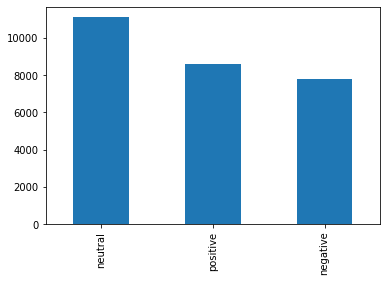

In [ ]:
# See how prevalent each sentiment are in the training data
print(train_data['sentiment'].value_counts())

train_data['sentiment'].value_counts().plot(kind='bar')

Most tweets in the training set are neutral, and the split between positive and negative is pretty even. This means the data are not really biased towards certain sentiments compared to others.

In [ ]:
# Drop the empty row
train_data = train_data.replace(r'^\s*$', np.nan, regex=True)
train_data.dropna(inplace=True)
print('Dimensions of the training data are now: ', train_data.shape)

Dimensions of the training data are now:  (27480, 4)


In [ ]:
# View a consise summary of the training dataframe, including whether there are any null objects
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [ ]:
# View a consise summary of the test dataframe, including whether there are any null objects
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


Summary: The training dataset has four columns: textID, text, selected_text, and sentiment. The test dataset has the same minus the selected_text column. The selected_text column contains a selection of the tweet that is best associated with the sentiment. It contains only one subsection of the text. Something to keep in mind during the next preparation phase is that the selected_text should not only consider the words, but also the spacing and extra characters such as punctuation marks. Some of the selected_text, for example, has irrelevant or strange start and end points, such as "o quite like lily allen and her music, to be honest." for the tweet "i'm actually starting to quite like lily allen and her music, to be honest."

# Prep Data for the Model


In [ ]:
def make_question(que):
  '''Parameter que is a pandas column with the sentiment.
  Returns the sentiment in question format. '''

  if que == 'positive':
    return 'positive tweet?'
  if que == 'neutral':
    return 'neutral tweet?'
  if que == 'negative':
    return 'negative tweet?'

In [ ]:
# Add new column with the sentiments as questions
train_data['sentiment_que'] = train_data['sentiment'].apply(make_question)
test_data['sentiment_que'] = test_data['sentiment'].apply(make_question)

train_data.head()

,textID,text,selected_text,sentiment,sentiment_que
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,neutral tweet?
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,negative tweet?
2,088c60f138,my boss is bullying me...,bullying me,negative,negative tweet?
3,9642c003ef,what interview! leave me alone,leave me alone,negative,negative tweet?
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,negative tweet?


In [ ]:
# Find the start index of the selected_text in relation to the text column
# and put in new column
train_data = train_data.fillna('')
train_data['answer_index'] = train_data.apply(lambda x: str.find(x['text'],
                                 x['selected_text']), axis=1)
train_data.head()

,textID,text,selected_text,sentiment,sentiment_que,answer_index
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,neutral tweet?,1
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,negative tweet?,1
2,088c60f138,my boss is bullying me...,bullying me,negative,negative tweet?,11
3,9642c003ef,what interview! leave me alone,leave me alone,negative,negative tweet?,17
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,negative tweet?,1


In [ ]:
# Split the training dataframe into a training and eval (validation)
train_data = train_data.head(n=13144)
eval_data = train_data.tail(n=3290)

print('Size of training set: ', len(train_data))
print('Size of eval set: ', len(eval_data))

Size of training set:  13144
Size of eval set:  3290


The data needs to be in a very particular format for the model. I ran the code from the [Keras BERT Encoder QA model code](https://keras.io/examples/nlp/text_extraction_with_bert/) I referenced in the beginning and modelled the list of dictionaries after it. It is similar to but not the same as the list of dictionaries I needed for the DistilBERT model.

In [ ]:
def prep_data(df, qa_list):
  '''Parameter df is training or test data.
  Returns the reformatted data.'''

  for ind in df.index:

    main_d = dict()

    # The context in this QA model is the full tweet
    context = df.loc[ind, "text"].lower()
    main_d["context"] = context

    qas=[]
    inside_qas={}

    # The answer in this QA model is the selected_text
    inside_answer=[{"answer_start": int(df.loc(axis=0)[ind, "answer_index"]),
                    "text": df.loc[ind, "selected_text"].lower()}]
    inside_qas["answers"] = inside_answer

    # The question in this QA model is the sentiment
    inside_qas["id"] = df.loc[ind, "textID"]
    inside_qas["question"] = df.loc[ind,"sentiment_que"]

    qas.append(inside_qas)

    main_d["qas"] = qas

    qa_list.append(main_d)

  return qa_list

In [ ]:
def prep_eval_data(df, qa_list):
  '''Parameter df is training or test data.
  Returns the reformatted data.'''

  for ind in df.index:

    main_d = dict()

    # The context in this QA model is the full tweet
    context = df.loc[ind, "text"].lower()
    main_d["context"] = context

    qas=[]
    inside_qas={}

    # The answer in this QA model is the selected_text
    inside_answer=[{"answer_start": int(df.loc(axis=0)[ind, "answer_index"]),
                    "text": df.loc[ind, "selected_text"].lower()}]
    inside_qas["answers"] = inside_answer

    # The question in this QA model is the sentiment
    inside_qas["answer_start"] = int(df.loc(axis=0)[ind, "answer_index"])
    inside_qas["text"] = df.loc[ind, "selected_text"].lower()

    # The question in this QA model is the sentiment
    inside_qas["id"] = df.loc[ind, "textID"]
    inside_qas["question"] = df.loc[ind,"sentiment_que"]

    qas.append(inside_qas)

    main_d["qas"] = qas

    qa_list.append(main_d)

  return qa_list

In [ ]:
# Transform the data to the list of dictionaries
qa_train_data = []
qa_test_data = []

train_data_prepped = prep_data(train_data, qa_train_data)
eval_data_prepped = prep_data(eval_data, qa_test_data)

print('Prepped training data: ', train_data_prepped[:2])
print('Prepped testing data: ', eval_data_prepped[:2])

Prepped training data:  [{'context': ' i`d have responded, if i were going', 'qas': [{'answers': [{'answer_start': 1, 'text': 'i`d have responded, if i were going'}], 'id': 'cb774db0d1', 'question': 'neutral tweet?'}]}, {'context': ' sooo sad i will miss you here in san diego!!!', 'qas': [{'answers': [{'answer_start': 1, 'text': 'sooo sad'}], 'id': '549e992a42', 'question': 'negative tweet?'}]}]
Prepped testing data:  [{'context': ' i know what appeals to you with knitting! believe me i know!', 'qas': [{'answers': [{'answer_start': 43, 'text': 'believe me i know!'}], 'id': 'c501e02cab', 'question': 'positive tweet?'}]}, {'context': 'making a life w/o bounds! t-shirt for second life', 'qas': [{'answers': [{'answer_start': 0, 'text': 'making a life w/o bounds! t-shirt for second life'}], 'id': '6cedca1722', 'question': 'neutral tweet?'}]}]


In [ ]:
# I also need to add a top level paragraphs dictionary for some reason.
raw_train_data = {
  'paragraphs': train_data_prepped
}

raw_eval_data = {
  'paragraphs': eval_data_prepped
}

In [ ]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

In [ ]:
# This entire class is almost word for word copied from the Keras example.
# It does a lot of data preprocessing.
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text, all_answers):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.all_answers = all_answers
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
            is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets

def create_squad_examples(raw_data):
    squad_examples = []
    for para in raw_data["paragraphs"]:
        context = para["context"]
        for qa in para["qas"]:
            question = qa["question"]
            answer_text = qa["answers"][0]["text"]
            all_answers = [_["text"] for _ in qa["answers"]]
            start_char_idx = qa["answers"][0]["answer_start"]
            squad_eg = SquadExample(
                question, context, start_char_idx, answer_text, all_answers)
            squad_eg.preprocess()
            squad_examples.append(squad_eg)
    return squad_examples


def create_inputs_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [dataset_dict["start_token_idx"], dataset_dict["end_token_idx"]]
    return x, y

In [ ]:
train_squad_examples = create_squad_examples(raw_train_data)
x_train, y_train = create_inputs_targets(train_squad_examples)
print(f"{len(train_squad_examples)} training points created.")

eval_squad_examples = create_squad_examples(raw_eval_data)
x_eval, y_eval = create_inputs_targets(eval_squad_examples)
print(f"{len(eval_squad_examples)} evaluation points created.")

13144 training points created.
3290 evaluation points created.


In [ ]:
# Take a look under the hood
print('x train: ', x_train[0])
print('x eval: ', x_eval[0])
print('y train: ', y_train[0])
print('y eval: ', y_eval[0])

x train:  [[  101 17111  2080 ...     0     0     0]
 [  101  2026  5795 ...     0     0     0]
 [  101  4124  1997 ...     0     0     0]
 ...
 [  101  2052  2293 ...     0     0     0]
 [  101  1999  2060 ...     0     0     0]
 [  101  1035 11608 ...     0     0     0]]
x eval:  [[  101  4771  1996 ...     0     0     0]
 [  101  2559  2830 ...     0     0     0]
 [  101  1045  4687 ...     0     0     0]
 ...
 [  101  2052  2293 ...     0     0     0]
 [  101  1999  2060 ...     0     0     0]
 [  101  1035 11608 ...     0     0     0]]
y train:  [ 1  4  1 ...  2  6 16]
y eval:  [ 1  1  2 ...  2  6 16]


# Build model

In [ ]:
# Define hyperparameter values
epochs = 5
learn_rate = 0.00005

In [ ]:
def create_model():
  '''Network with the following layers:
  encoder, 3xinputs+encoder, dense, flatten, 2xactivation
  With categorical cross entropy loss function and Adam optimizer
  '''

  ## BERT encoder
  encoder = TFBertModel.from_pretrained("bert-base-uncased")

  ## QA Model
  input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
  token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
  attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
  embedding = encoder(
      input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
  )[0]

  start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
  start_logits = layers.Flatten()(start_logits)

  end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
  end_logits = layers.Flatten()(end_logits)

  start_probs = layers.Activation(keras.activations.softmax)(start_logits)
  end_probs = layers.Activation(keras.activations.softmax)(end_logits)

  model = keras.Model(
      inputs=[input_ids, token_type_ids, attention_mask],
      outputs=[start_probs, end_probs],
  )
  loss = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
  optimizer = keras.optimizers.Adam(lr=5e-5)
  model.compile(optimizer=optimizer, loss=[loss, loss])
  return model

In [ ]:
model = create_model()

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 141)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 141)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 141)]        0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   ((None, 141, 768), ( 109482240   input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
# These functions are also taken almost word-for-word from the Keras
# tutorial cited at the beginning of this notebook. Evaluation metric
# for prediction accuracy

def normalize_text(text):
    return text


class ExactMatch(keras.callbacks.Callback):
    """
    Each object contains the character level offsets for each token
    in its input paragraph. They are used to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each object.
    Also calculate the percentage of data points where the span of text obtained
    from model predictions matches the ground-truth answers.
    """

    def __init__(self, x_eval, y_eval):
        self.x_eval = x_eval
        self.y_eval = y_eval

    def on_epoch_end(self, epoch, logs=None):
        pred_start, pred_end = self.model.predict(self.x_eval)
        count = 0
        eval_examples_no_skip = [_ for _ in eval_squad_examples if _.skip == False]
        for idx, (start, end) in enumerate(zip(pred_start, pred_end)):
            squad_eg = eval_examples_no_skip[idx]
            offsets = squad_eg.context_token_to_char
            start = np.argmax(start)
            end = np.argmax(end)
            if start >= len(offsets):
                continue
            pred_char_start = offsets[start][0]
            if end < len(offsets):
                pred_char_end = offsets[end][1]
                pred_ans = squad_eg.context[pred_char_start:pred_char_end]
            else:
                pred_ans = squad_eg.context[pred_char_start:]

            normalized_pred_ans = normalize_text(pred_ans)
            normalized_true_ans = [normalize_text(_) for _ in squad_eg.all_answers]
            if normalized_pred_ans in normalized_true_ans:
                count += 1
        acc = count / len(self.y_eval[0])
        print(f"\nepoch={epoch+1}, exact match score={acc:.2f}")

In [ ]:
exact_match_callback = ExactMatch(x_eval, y_eval)
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=32,
    callbacks=[exact_match_callback],
)

Epoch 1/5

epoch=1, exact match score=0.26
165/165 - 96s - loss: 3.2895 - activation_9_loss: 1.4414 - activation_10_loss: 1.8481
Epoch 2/5

epoch=2, exact match score=0.34
165/165 - 93s - loss: 2.1251 - activation_9_loss: 0.9272 - activation_10_loss: 1.1980
Epoch 3/5

epoch=3, exact match score=0.42
165/165 - 93s - loss: 1.3672 - activation_9_loss: 0.6012 - activation_10_loss: 0.7660
Epoch 4/5

epoch=4, exact match score=0.45
165/165 - 93s - loss: 0.7705 - activation_9_loss: 0.3509 - activation_10_loss: 0.4195
Epoch 5/5

epoch=5, exact match score=0.46
165/165 - 93s - loss: 0.4661 - activation_9_loss: 0.2192 - activation_10_loss: 0.2469


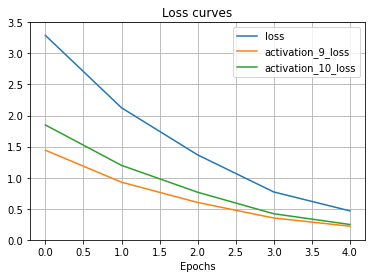

In [ ]:
# This code is adapted from Geron figure 10-12.
def learning_curves():
  pd.DataFrame(history.history).plot()
  plt.grid(True)
  plt.xlabel('Epochs')
  plt.title('Loss curves')
  plt.gca().set_ylim(0,3.5)
  plt.show()

learning_curves()

In [ ]:
# Run with a validation split
history = model.fit(
    x_train,
    y_train,
    epochs=epochs,
    verbose=2,
    batch_size=64,
    validation_split=0.2,
)

Epoch 1/5
66/66 - 74s - loss: 0.2180 - activation_9_loss: 0.0995 - activation_10_loss: 0.1185 - val_loss: 0.0906 - val_activation_9_loss: 0.0463 - val_activation_10_loss: 0.0443
Epoch 2/5
66/66 - 71s - loss: 0.1167 - activation_9_loss: 0.0499 - activation_10_loss: 0.0668 - val_loss: 0.0936 - val_activation_9_loss: 0.0483 - val_activation_10_loss: 0.0453
Epoch 3/5
66/66 - 71s - loss: 0.0906 - activation_9_loss: 0.0405 - activation_10_loss: 0.0501 - val_loss: 0.0957 - val_activation_9_loss: 0.0393 - val_activation_10_loss: 0.0563
Epoch 4/5
66/66 - 71s - loss: 0.0683 - activation_9_loss: 0.0323 - activation_10_loss: 0.0361 - val_loss: 0.1022 - val_activation_9_loss: 0.0490 - val_activation_10_loss: 0.0532
Epoch 5/5
66/66 - 71s - loss: 0.0464 - activation_9_loss: 0.0205 - activation_10_loss: 0.0259 - val_loss: 0.1320 - val_activation_9_loss: 0.0602 - val_activation_10_loss: 0.0718


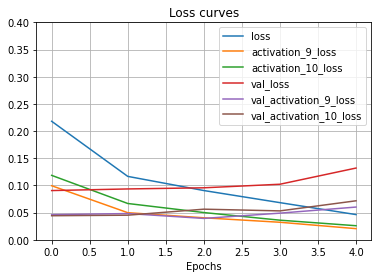

In [ ]:
# This code is adapted from Geron figure 10-12.
def learning_curves():
  pd.DataFrame(history.history).plot()
  plt.grid(True)
  plt.xlabel('Epochs')
  plt.title('Loss curves')
  plt.gca().set_ylim(0,0.4)
  plt.show()

learning_curves()

This figure suggests there could be some problem with overfitting the data. The validation loss curve actually increases over time, while the overall loss decreases. However, the validation loss for the activation layers decrease over epochs.

# Final Solution

In [ ]:
# Save the solution as a CSV file for Kaggle
#pd.to_csv('filename.csv',index = False)
#test_df[['textID','selected_text']].to_csv('submission.csv',index=False)